In [142]:
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client
import pde
import phasesep as ps
import numpy as np
from skimage.measure import label, regionprops
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from IPython.display import Image
import tracker

 ## Setting  up Dask cluster

In [143]:
cluster = HTCondorCluster(
    cores=8,
    memory="8GB",
    disk="16GB",
    processes=8,
    local_directory="$TMPDIR",
    log_directory="/home/ole.berendes/dasklogs",
    job_extra={"+MaxRunTime": 86400}
)

In [144]:
cluster.scale(jobs=2)
cluster


In [145]:
client = Client(cluster)


In [146]:
client

<Client: 'tcp://134.76.97.134:8558' processes=0 threads=0, memory=0 B>

 ## Setting up the system

 ### Free energy density

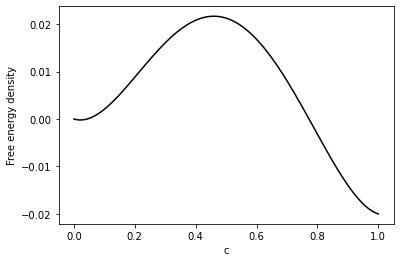

In [147]:
f_scale = 1
f_slope = -0.02
f_offset = 0

f = ps.GinzburgLandau2Components(
    prefactor=f_scale,
    slope=f_slope,
    offset=f_offset
)
f.plot()

In [148]:
binodal = f.get_binodal()[0][0]
spinodal = f.get_spinodal()[0]
binodal_range = spinodal - binodal


 ### Equation

In [149]:
kappa = 1
diffusive_mobility = 1
noise_diffusion = 2/30

eq = ps.CahnHilliardExtendedPDE(
    {
        "free_energy": f,
        "kappa": kappa,
        "mobility": diffusive_mobility,
        "noise_diffusion": noise_diffusion
    }
)
eq.cache_rhs = True


 ## Simulation

 ### Define grid

In [150]:
length_scale = 1

nx, ny = 32, 32
x_start, x_end = -nx/2*length_scale, nx/2*length_scale
y_start, y_end = -ny/2*length_scale, ny/2*length_scale
grid = pde.CartesianGrid(
    bounds=[(x_start, x_end), (y_start, y_end)],
    shape=[nx,ny],
    periodic=True)


 ### Initial state

0.05283121635129673


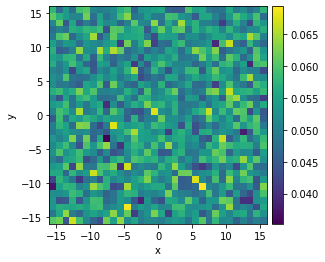

In [151]:
phi0 = binodal + 0.25*binodal_range

initial_field = pde.ScalarField.random_normal(
    grid=grid,
    mean=phi0,
    std=phi0*0.1
)
print(phi0)
initial_field.plot()

In [ ]:
dt = 1e-3
def run_inital_sampling(initial_state, t_end, filename_base, monitorfile, dt=dt, eq=eq):



    opar = tracker.DropletMaterialTracker(op_max=3.03, op_min=-1, ncrossings=100)
    storage = pde.MemoryStorage(field_obj=initial_state, write_mode="truncate_once")
    stor = storage.tracker()
    plot = pde.PlotTracker(interval=60, output_file=monitorfile)
    final = eq.solve(
        state=initial_state,
        t_range=t_end,
        tracker=[stor, plot, opar],
        method="explicit",
        dt=dt
    )
    traj_file = filename_base+"_trajectory.npz"
    states_file = filename_base+"_crossed_states.npz"
    np.savez_compressed(traj_file, *storage.data)
    np.savez_compressed(states_file, *opar.crossed_states)
    return opar


In [153]:
runs = []
for i in range(16):
    filename_base = f"/home/ole.berendes/data/SIM09-{i}"
    monitor = f"/home/ole.berendes/monitor_{i}.png"
    fut = client.submit(
        run_inital_sampling,
        initial_field,
        1e5,
        filename_base,
        monitor
    )
    runs.append(fut)

In [ ]:
runs

In [ ]:
from IPython.display import Image
Image(filename='/home/ole.berendes/monitor_10.png')

## Analysis

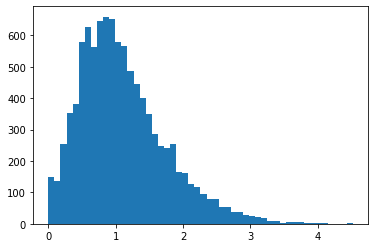

In [82]:
run = future.result()
ops = run.op_history
plt.hist(ops, bins=50)
plt.show()

In [90]:
print("Mean: ", np.mean(ops))
print("Mean+Std:",np.mean(ops)+np.std(ops))
print("99th percentil: ",np.percentile(ops, 99))

Mean:  1.1064469495819753
Mean+Std: 1.7461796368304847
99th percentil:  3.031574021699152


Use $\lambda_A = 1.11$ and $\lambda_0 = 3.03$.

## Clean up

In [ ]:
client.close()
cluster.close()
